In [88]:
#Importing libraries

import pandas as pd
import math
import glob

import seaborn as sns
import matplotlib.pyplot as plt

#retrieving all data files from folder
files = glob.glob(r"C:\Users\allan\OneDrive\Desktop\Documentos\Mis Análsis\Mercamadrid\data\volpre*.csv")


dfs = [pd.read_csv(f, encoding="ISO-8859-1", sep=';', decimal=',') for f in files]
df=pd.concat(dfs, ignore_index=True)

#Checking initial structure
print (df.head())
print (df.info())

  Fecha Desde  Fecha Hasta  Código Variedad             Descripción Variedad  \
0    20210101     20210131          CA 0101   VACUNO CANAL                     
1    20210101     20210131          CA 0101   VACUNO CANAL                     
2    20210101     20210131          CA 0101   VACUNO CANAL                     
3    20210101     20210131          CA 0101   VACUNO CANAL                     
4    20210101     20210131          CA 0101   VACUNO CANAL                     

   Origen     Descripción Origen       Kilos  Precio Más Frecuente  \
0     005   AVILA                  000002220                  4,27   
1     008   BARCELONA              000066910                  4,29   
2     010   CACERES                001327305                  4,29   
3     015   LA CORUÑA              000052640                   4,3   
4     017   GERONA                 000010440                  4,28   

   Precio Máximo  Precio Mínimo  
0           4,27           4,27  
1           4,31           4,2

In [89]:
#Verifying how columns are named to avoid Key errors
df.columns = df.columns.str.replace(' ','')
df.columns

Index(['FechaDesde', 'FechaHasta', 'CódigoVariedad', 'DescripciónVariedad',
       'Origen', 'DescripciónOrigen', 'Kilos', 'PrecioMásFrecuente',
       'PrecioMáximo', 'PrecioMínimo'],
      dtype='object')

In [90]:
#Dates cleaning

df["FechaHasta"] = df["FechaHasta"].astype('str').str.strip();

#Converting dates to datetime format
df["FechaDesde"]=pd.to_datetime(df["FechaDesde"],format="%Y%m%d", errors="coerce");
df["FechaHasta"]=pd.to_datetime(df["FechaHasta"],format="%Y%m%d", errors="coerce");


In [91]:
#Searching for nulls

null_vars = df.isna().sum().sort_values(ascending=False)
null_vars

FechaDesde             52
FechaHasta             52
CódigoVariedad          0
DescripciónVariedad     0
Origen                  0
DescripciónOrigen       0
Kilos                   0
PrecioMásFrecuente      0
PrecioMáximo            0
PrecioMínimo            0
dtype: int64

In [92]:
#Counting missing dates

total_rows = df.shape[0]
missing_dates = df[df["FechaDesde"].isna() | df["FechaHasta"].isna()].shape[0];

md_percentage = (missing_dates / total_rows)*100
print(f"Mssing Percentage: {(md_percentage):.2f}%, Total Missing: {missing_dates}, Total Rows: {total_rows}")

Mssing Percentage: 0.03%, Total Missing: 52, Total Rows: 187011


In [93]:
#Removing nulls
df = df.dropna()

#Checking new number of nulls
df.isna().sum().sort_values(ascending=False)

FechaDesde             0
FechaHasta             0
CódigoVariedad         0
DescripciónVariedad    0
Origen                 0
DescripciónOrigen      0
Kilos                  0
PrecioMásFrecuente     0
PrecioMáximo           0
PrecioMínimo           0
dtype: int64

In [94]:
#Converting prices from string to float
cols=["PrecioMáximo","PrecioMínimo","PrecioMásFrecuente"]

df[cols]=(
    df[cols].apply(
        lambda col:col
        .str.strip()
        .str.replace(',','.',regex=False)
        .astype(float)
    )
)

#Verifying conversion
df.head()

,FechaDesde,FechaHasta,CódigoVariedad,DescripciónVariedad,Origen,DescripciónOrigen,Kilos,PrecioMásFrecuente,PrecioMáximo,PrecioMínimo
0,2021-01-01,2021-01-31,CA 0101,VACUNO CANAL,005,AVILA,000002220,4.27,4.27,4.27
1,2021-01-01,2021-01-31,CA 0101,VACUNO CANAL,008,BARCELONA,000066910,4.29,4.31,4.27
2,2021-01-01,2021-01-31,CA 0101,VACUNO CANAL,010,CACERES,001327305,4.29,4.31,4.27
3,2021-01-01,2021-01-31,CA 0101,VACUNO CANAL,015,LA CORUÑA,000052640,4.30,4.31,4.27
4,2021-01-01,2021-01-31,CA 0101,VACUNO CANAL,017,GERONA,000010440,4.28,4.28,4.28


In [95]:
#Filtering products that have at least 24 records so I can calculate seasonality later
product_counts = df["DescripciónVariedad"].value_counts()
min_required = 24

df = df[df["DescripciónVariedad"].isin(product_counts[product_counts>=min_required].index)]

In [96]:
#Setting dates dimmension
df["Año"] = df["FechaDesde"].dt.year
df["Mes"] = df["FechaDesde"].dt.month

#Order by product and date
df = df.sort_values(["DescripciónVariedad","FechaDesde"])

#Calculating price monthly variation
df["PrecioDiff"] = df.groupby("DescripciónVariedad")["PrecioMásFrecuente"].diff()

#Calculating CV
cv = df.groupby("DescripciónVariedad")["PrecioMásFrecuente"].std()/df.groupby("DescripciónVariedad")["PrecioMásFrecuente"].mean()
df_cv=cv.reset_index().rename(columns={"PrecioMásFrecuente":"CoefVar"})
#df_cv.head()

In [97]:
#Seasonality Analysis

#Para el análisis de volatilidad y estacionalidad se utiliza el PrecioMásFrecuente, ya que representa el comportamiento típico del mercado y reduce el impacto de valores extremos puntuales.

df["PrecioBase"] = df["PrecioMásFrecuente"]

In [98]:
volatilidad_producto = (
    df.groupby("DescripciónVariedad")["PrecioBase"]
    .agg(["mean","std"])
    .assign(CV=lambda x:x["std"]/x["mean"])
    .reset_index()
    .sort_values("CV",ascending=False)
)

volatilidad_producto

,DescripciónVariedad,mean,std,CV
355,OVINO CASQUERIA,1.115536,1.114583,0.999146
425,PORCINO CASQUERIA,0.996861,0.860685,0.863395
123,CEREZAS O.V.,6.427238,5.371735,0.835777
518,VIEIRAS CONG,8.740962,6.301579,0.720925
119,CEBOLLINO,4.417478,2.896353,0.655658
...,...,...,...,...
438,QUINTA GAMA HORTALIZAS,0.000000,0.000000,NaN
511,VACUNO CONG. SIN ESPECIF,0.000000,0.000000,NaN
512,VACUNO DESPIECE,0.000000,0.000000,NaN
515,VACUNO ELABORADO,0.000000,0.000000,NaN


In [99]:
#defining tresholds

q_low  = volatilidad_producto["CV"].quantile(0.33)
q_high = volatilidad_producto["CV"].quantile(0.66)

def vol_class(cv):
    if cv < q_low:
        return "Estable"
    if cv >= q_high:
        return "Volátil"
    else:
        return "Intermedio"

volatilidad_producto["PerfilPrecio"] = volatilidad_producto["CV"].apply(vol_class)

In [100]:
#Counting volatile products
total = volatilidad_producto.shape[0]
volatiles= (volatilidad_producto["PerfilPrecio"]=="Volátil").sum()

percentage = f"{(volatiles/total)*100:.2f}%"
percentage

'32.82%'

In [ ]:
###“Aproximadamente un tercio de los productos presentan un comportamiento altamente volátil, lo que sugiere la necesidad de estrategias específicas de compra o contratos anticipados.”

In [101]:
precio_mensual=(
    df.groupby(["DescripciónVariedad","Mes"])["PrecioBase"]
    .mean()
    .reset_index()
)

In [73]:
#“Dado que no existe una clasificación por categorías, el análisis de estacionalidad se realiza a nivel de variedad de producto.”

In [102]:
#“Para facilitar la interpretación visual, 
#se analizan las 10 variedades con mayor número de registros.”

top_productos = (
    df["DescripciónVariedad"].value_counts()
    .head(10)
    .index
)

precio_mensual_top=precio_mensual[precio_mensual["DescripciónVariedad"].isin(top_productos)]
precio_mensual_top

,DescripciónVariedad,Mes,PrecioBase
4101,PATATA AGRIA GRANEL,1,0.468968
4102,PATATA AGRIA GRANEL,2,0.502411
4103,PATATA AGRIA GRANEL,3,0.526901
4104,PATATA AGRIA GRANEL,4,0.548162
4105,PATATA AGRIA GRANEL,5,0.586861
...,...,...,...
5679,VACUNO DESPIECE VACA,8,11.537927
5680,VACUNO DESPIECE VACA,9,11.607772
5681,VACUNO DESPIECE VACA,10,11.050988
5682,VACUNO DESPIECE VACA,11,11.609610


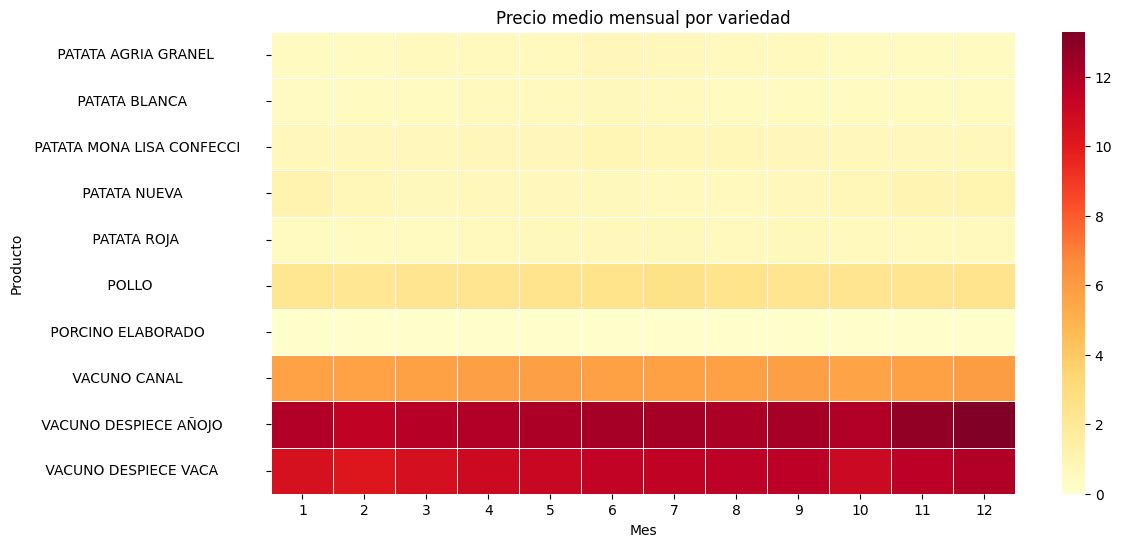

In [103]:
heatmap_data = precio_mensual_top.pivot(
    index="DescripciónVariedad",
    columns="Mes",
    values="PrecioBase"
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    linewidths=0.5
)

plt.title("Precio medio mensual por variedad")
plt.xlabel("Mes")
plt.ylabel("Producto")
plt.show()

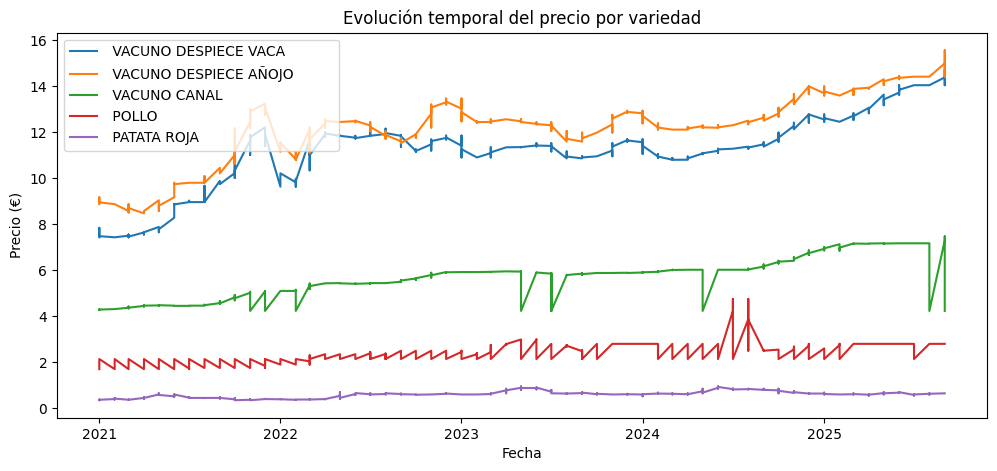

In [105]:
#“Algunas variedades presentan picos abruptos y caídas pronunciadas, mientras que otras muestran una evolución más estable, reforzando la clasificación previa de productos volátiles vs estables.”

productos_plot = top_productos[:5]

df_ts = df[df["DescripciónVariedad"].isin(productos_plot)]

plt.figure(figsize=(12, 5))

for p in productos_plot:
    data_p = df_ts[df_ts["DescripciónVariedad"] == p]
    plt.plot(data_p["FechaDesde"], data_p["PrecioBase"], label=p)

plt.legend()
plt.title("Evolución temporal del precio por variedad")
plt.xlabel("Fecha")
plt.ylabel("Precio (€)")
plt.show()


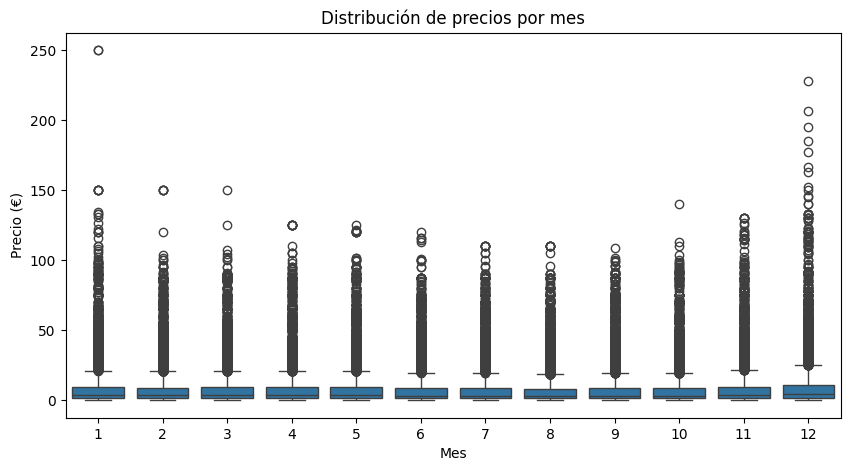

In [106]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df,
    x="Mes",
    y="PrecioBase"
)

plt.title("Distribución de precios por mes")
plt.xlabel("Mes")
plt.ylabel("Precio (€)")
plt.show()


In [ ]:
#“Las visualizaciones confirman la existencia de patrones estacionales en determinadas variedades, así como diferencias significativas en la estabilidad de precios. Esta información es clave para planificar compras y reducir la exposición a meses de mayor riesgo.”

In [109]:
# Para cada producto, calculamos el precio medio anual
precio_anual = df.groupby("DescripciónVariedad")["PrecioBase"].mean().reset_index()
precio_anual = precio_anual.rename(columns={"PrecioBase":"PrecioMedioAnual"})

# Unimos al precio mensual
precio_mensual_insights = precio_mensual.merge(precio_anual, on="DescripciónVariedad")

# Definimos un mes crítico si el precio supera +15% del promedio anual
precio_mensual_insights["MesCritico"] = precio_mensual_insights["PrecioBase"] > 1.15 * precio_mensual_insights["PrecioMedioAnual"]

# Revisamos algunos casos
precio_mensual_insights.head(1500)


,DescripciónVariedad,Mes,PrecioBase,PrecioMedioAnual,MesCritico
0,ABADEJO,1,5.796667,5.596069,False
1,ABADEJO,2,5.545455,5.596069,False
2,ABADEJO,3,5.500000,5.596069,False
3,ABADEJO,4,5.928571,5.596069,False
4,ABADEJO,5,5.454545,5.596069,False
...,...,...,...,...,...
1495,CIGALAS GRANDES,8,76.671333,91.928397,False
1496,CIGALAS GRANDES,9,73.677143,91.928397,False
1497,CIGALAS GRANDES,10,93.756190,91.928397,False
1498,CIGALAS GRANDES,11,105.704583,91.928397,False


In [112]:
meses_criticos = (
    precio_mensual_insights[precio_mensual_insights["MesCritico"]]
    .groupby("DescripciónVariedad")["Mes"]
    .apply(list)
    .reset_index()
    .rename(columns={"Mes": "MesesAltosPrecios"})
)

meses_criticos.head(100)


,DescripciónVariedad,MesesAltosPrecios
0,ACEDIAS,[8]
1,ACELGAS,[1]
2,ACHICORIA,[6]
3,AGUACATE HASS,[4]
4,ALBARICOQUE COMUN,"[1, 2, 3, 4, 11, 12]"
...,...,...
95,GALLO MEDIANO,"[1, 11]"
96,GALLO PEQUEÑO,"[1, 11]"
97,GAMBAS GIGANTES,"[11, 12]"
98,GAMBAS PLANCHA,[12]


In [111]:
productos_volatiles = volatilidad_producto[volatilidad_producto["PerfilPrecio"]=="Volátil"]

recomendaciones = meses_criticos.merge(productos_volatiles[["DescripciónVariedad","CV"]], on="DescripciónVariedad", how="left")
